# Lab 2
## 4.1 Topological Ordering of Animal Species

In particular, your task is to write the core algorithm. Use a weight matrix of size 100 × 84 initialized with random numbers between zero and one. Use an outer loop to train the network for about 20 epochs, and an inner loop which loops through the 32 animals, one at a time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ANIMALS = 32
DIMS = 84
HIDDEN_NODES = 100

In [3]:
def get_data(file='animals'):
    if file == 'animals':
        filename = "data/animals.dat"
        props = np.zeros((ANIMALS, DIMS))
        with open(filename) as f:
            data = f.read().split(',')
            for ndx in range(ANIMALS):
                props[ndx,:] = data[ndx*DIMS : (ndx+1)*DIMS]
        return props
        

In [36]:
def get_weights(size, sd=0.01):
    return np.random.normal(0, sd, size)

In [37]:
weights = get_weights((HIDDEN_NODES, DIMS))
props = get_data()

### SOM Algorithm
1. Calculate the similarity between the input pattern and the weights arriving at each output node.
2. Find the most similar node; *winner*
3. Select a set of output nodes which are located close to the winner *in the output grid*; *neighbourhood*.
4. Update the weights of all nodes in the neighbourhood such that their weights are moved closer to the input pattern

Make the size of the neighbourhood depend on the epoch loop variable so that you start with a neighbourhood of about 50 and end up close to one or zero.

In [55]:
def neighborhood(ndx, epoch, max_range):
    nbrhd_range = int(50 - epoch*2.5)
    nbrhd_min = np.max([0, ndx-nbrhd_range])
    nbrhd_max = np.min([max_range, ndx+nbrhd_range])
    return np.arange(nbrhd_min, nbrhd_max)

In [56]:
def train_SOM(props, weights, step_size=0.2, epochs=20, eta=0.2):
    for epoch in range(epochs):
        for animalNdx in range(ANIMALS):
            # Calculate similarity between input pattern and weights
            #  Ignore Sqrt since we only care about the winner
            similarity = np.sum(
                np.square(props[animalNdx,:]-weights), axis=1)
            # Select winner
            winner = np.argmin(similarity)
            # Update weights in neighborhood
            nbrs = neighborhood(winner, epoch, HIDDEN_NODES)
            weights[nbrs,:] = weights[nbrs,:] + \
              eta*(props[animalNdx,:] - weights[nbrs,:])
    return weights

In [57]:
w_trained = train_SOM(props, weights)

In [58]:
def get_animal_names():
    with open("data/animalnames.txt") as f:
            animals = f.read().replace("\t\n'", '')
    animals = animals.replace("\n", "").replace("''", "'").split("'")
    return animals[1:len(animals)-1]

Sort based on output nodes:
Animals next to each other in the listing should always have some similarity between them. Insects should typically be grouped together, separate from the di􏰃erent cats, for example.

In [59]:
def print_ordering(props, weights):
    pos = {}
    for animalNdx in range(ANIMALS):
        similarity = np.sum(
            np.square(props[animalNdx,:] - weights), axis=1)
        pos[animalNdx] = np.argmin(similarity)

    sorted_pos = sorted(pos.items(), key=lambda kv: kv[1])
    animal_names = get_animal_names()
    for ndx in sorted_pos:
        print(animal_names[ndx[0]])

In [63]:
print_ordering(props, w_trained)

beetle
dragonfly
grasshopper
butterfly
moskito
housefly
spider
duck
pelican
penguin
ostrich
frog
seaturtle
crocodile
walrus
bear
hyena
dog
ape
cat
lion
skunk
rat
bat
elephant
kangaroo
rabbit
antelop
horse
camel
giraffe
pig


## 3.3 Competitive learning (CL) to initialize RBF units

In [377]:
# Network and data params
RBF_UNITS = 35
RBF_VAR = 0.1

X_MIN = 0
X_MAX = 2*np.pi

In [378]:
# Data
patterns = np.arange(0, X_MAX, 0.1)
test_set = np.arange(0.05, X_MAX, 0.1)
patterns = patterns.reshape((1, len(patterns)))
test_set = test_set.reshape((1, len(test_set)))

sin_2x = np.sin(2*patterns)
square_2x = np.square(2*patterns)

In [379]:
# Helper class for an RBF-unit
class unit:
    def __init__(self, mu, var):
        self.mu = mu
        self.var = var
        self.sd = np.sqrt(var)

In [380]:
def get_weights(size, sd=0.01):
    return np.random.normal(0, sd, size)

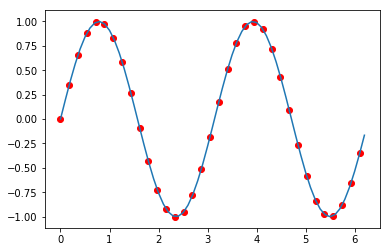

(35, 1)

In [455]:
# Spec network
# means = np.random.choice(patterns[0,:], RBF_UNITS)
means = np.arange(0, X_MAX, X_MAX/RBF_UNITS)
units = [unit(means[row], RBF_VAR) for row in range(RBF_UNITS)]
weights = get_weights((RBF_UNITS, 1)).reshape((RBF_UNITS, 1))

plt.scatter(means, np.sin(2*means), c = 'r')
plt.plot(patterns.T, sin_2x.T)
plt.show()

In [435]:
# Transformation function
def phi(x, unit):
    return np.exp(-np.square((x-unit.mu)) / (2*unit.var))

def get_phi_matrix(patterns, units):
    return np.array([[phi(patterns[0,pattern_ndx], units[unit_ndx])
                    for unit_ndx in range(len(units))]
                     for pattern_ndx in range(patterns.shape[1])])

In [436]:
def least_squares_weights(phi_matrix, labels):
    return np.dot(
        np.linalg.inv(np.dot(phi_matrix.T, phi_matrix)), 
        np.dot(phi_matrix.T, labels.T))

In [437]:
def residual_error(phi_matrix, weights, labels):
    return np.sum(
        np.abs(np.dot(phi_matrix, computed_weights) - labels.T)
    )/labels.shape[1]

In [482]:
def train_RBF(patterns, units, weights, labels, learning_rate=0.018):
    for data_ndx in range(patterns.shape[1]):
        # Compute Transformation function
        phi_pattern = np.array(
            [phi(patterns[0,data_ndx], unit) for unit in units]).reshape(1, len(units))

        # Predict output
        prediction = np.dot(phi_pattern, weights)
        
        np.dot(phi_pattern.T, weights.T)

        # Use instantaneous error, or derivative thereof
        # 1/2*np.square(labels[0,data_ndx] - prediction)
        
        dw = learning_rate*np.dot(
            labels[0,data_ndx] - np.dot(phi_pattern.T, weights.T),
            phi_pattern.T
        )
        weights = weights + dw
    return weights

In [483]:
phi_matrix = get_phi_matrix(patterns, units)
computed_weights = least_squares_weights(phi_matrix, sin_2x)
trained_weights = train_RBF(patterns, units, weights, sin_2x)

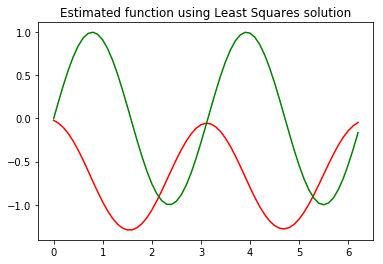

In [484]:
plt.title("Estimated function using Least Squares solution")
# plt.plot(patterns[0,:], np.dot(phi_matrix, computed_weights), c='y')
plt.plot(patterns[0,:], np.dot(phi_matrix, trained_weights), c='r')
plt.plot(patterns[0,:], sin_2x[0,:], c='g')

Residual error gets below 0.001 for 30 rbf-units, for >=35 units the error starts to increase. Variance = 0.1

In [389]:
print(residual_error(phi_matrix, weights, sin_2x))

0.0017843627004291373
